In [1]:
import os 
import sys
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import lognorm
from scipy.stats import norm 
from scipy import integrate
from scipy.stats import gmean

from scipy.stats import pearsonr

import statsmodels.api as sm 
import statsmodels.formula.api as smf

### src; https://github.com/arkottke/pyrotd
import pyrotd



In [3]:
with open('BuildingNames.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s1_48x32_high',
 's1_48x32_veryhigh',
 's1_96x48_high',
 's1_96x48_veryhigh',
 's2_48x32_high',
 's2_48x32_veryhigh',
 's2_96x48_high',
 's2_96x48_veryhigh',
 's4_96x48_high',
 's4_96x48_veryhigh']

In [4]:
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'

## time period of the buildings
T = np.array([0.13, 0.12, 0.22, 0.22, 0.16, 0.15, 0.26, 0.25, 0.49, 0.49])

numGM = 826
g = 980.665 ## converts GM record to cm/sec^2

def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [4]:
# heresi_GM_dir = os.path.join(baseDir, *['References', 'Heresi GMs'])
# os.chdir(heresi_GM_dir)
# heresiGM = pd.read_csv('Ground Motion Records.csv')
# RSNs = heresiGM['Record Sequence Number\n(NGA-West2)'].values
# np.savetxt('Heresi_831_RSNs.txt',[RSNs], delimiter=',', fmt='%d')

In [5]:
gminfo_h1 = pd.read_csv(r'data/Complete_GM_info_h1.csv')
gminfo_h1 = gminfo_h1.set_index('key_0')
gminfo_h1.index.names = ['GMID']

In [6]:
gminfo_h2 = pd.read_csv(r'data/Complete_GM_info_h2.csv')
gminfo_h2 = gminfo_h2.set_index('key_0')
gminfo_h2.index.names = ['GMID']

In [7]:
gminfo_rotD50 = pd.read_csv(r'data/Complete_GM_info_RotD50.csv')
gminfo_rotD50 = gminfo_rotD50.set_index('key_0')
gminfo_rotD50.index.names = ['GMID']
gminfo_rotD50.columns

Index(['PGA', 'PGV', 'DS_5to75', 'DS_5to95', 'CAV', 'T_0.01', 'T_0.02',
       'T_0.03', 'T_0.04', 'T_0.05',
       ...
       'SI', 'ASI', 'DSI', 'Sa_avg', '5-75% Duration (sec)_NGA2',
       '5-95% Duration (sec)_NGA2', 'Magnitude', 'Distance_Rjb',
       'Distance_rup', 'Vs_30'],
      dtype='object', length=156)

In [8]:
sv_rotD50 = pd.read_csv('data/Spectral_velocity_rotD50.csv', index_col='GMID')
sd_rotD50 = pd.read_csv('data/Spectral_Displacement_rotD50.csv', index_col='GMID')

In [9]:
# os.chdir(os.path.join(baseDir, *['Codes', 'data']))
# np.savetxt('Magnitude.txt', gminfo_rotD50['Magnitude'].values, fmt = '%.3f')
# np.savetxt('Distance_Rjb.txt', gminfo_rotD50['Distance_Rjb'].values, fmt = '%.3f')

## Defining Classes for efficiency and sufficiency

In [10]:
class OLS:
    def __init__(self, EDP, IM):
        self.EDP = EDP
        self.IM = IM
        self.Y = np.log(EDP)
        self.X = sm.add_constant(np.log(IM))
        
        self.residual_mean = None
        self.residual_std = None
        self.xmin = None
        self.xmax = None
        
        self.fitModel()
        self.get_summary()
        
#         self.plot_residuals_hist()
#         self.plot_model_fit()
        
    def fitModel(self):
        model = sm.OLS(self.Y, self.X)
        self.result = model.fit()
        
    def get_summary(self):
        return self.result.summary()
    
    def plot_residuals_hist(self):
        fig, ax = plt.subplots()
        sns.histplot(x = self.result.resid, ax=ax, stat = 'density', linewidth = 0, kde=True)
        ax.set(title = 'Distribution of residuals', xlabel = 'residuals')
        
        self.residual_mean, self.residual_std = norm.fit(self.result.resid)
        ##plotting normal pdf
        self.xmin, self.xmax = plt.xlim() # using maxi/min values from histogram
        x = np.linspace(self.xmin, self.xmax, 200)
        pdf = norm.pdf(x, self.residual_mean, self.residual_std)
        sns.lineplot(x = x, y = pdf, color = 'red', ax = ax)
        plt.show()
    
    def get_efficiency(self):
        return np.std(self.result.resid)
            
    def qqplot(self):
        sm.qqplot(self.result.resid, line = 's')


    def fitplot(self):
        sm.graphics.plot_fit(self.result, 1, vlines = False);
        
    def plot_model_fit(self):
        Ymin = self.Y.min()
        Ymax = self.Y.max()
#         ax = sns.subplots()
        ax = sns.scatterplot(x = self.result.fittedvalues, y = self.Y)
#         ax.set_ylim(Ymin, Ymax)
#         ax.set_xlim(self.xmin, self.xmax)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Observed Values')
        
        X_ref = Y_ref = np.linspace(Ymin, Ymax, 200)
        plt.plot(X_ref, Y_ref, color = 'red', linewidth = 1.3)
        plt.show()
        
class Sufficiency():
    def __init__(self, ln_EDP, ln_IM, Rjb, Mag):
        self.EDP = ln_EDP
        self.IM = ln_IM
        self.X = sm.add_constant(self.IM)
        
        temp = {'I': np.ones(shape = len(Mag)),
                'lnEDP': self.EDP,
                'lnIM': self.IM,
                'lnRjb': np.log(Rjb),
                'M': Mag}
        self.dummydf = pd.DataFrame(temp, index = None)
        
        self.sufficiency_against_R()
        self.sufficiency_against_M()
        self.sufficiency_against_M_and_R()
        
    def sufficiency_against_R(self):
        self.model_IM_vs_R = smf.ols('lnEDP ~ lnIM + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R.fit()
        self.summary_against_R = model_res.summary()
        return model_res.pvalues['lnRjb']
        
    def sufficiency_against_M(self):
        self.model_IM_vs_M = smf.ols('lnEDP ~ lnIM + M', data = self.dummydf)
        model_res = self.model_IM_vs_M.fit()
        self.summary_against_M = model_res.summary()
        return model_res.pvalues['M']

    def sufficiency_against_M_and_R(self):
        self.model_IM_vs_R_and_M = smf.ols('lnEDP ~ lnIM + M + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R_and_M.fit()
        self.summary_against_M_and_R = model_res.summary()
        return model_res.pvalues
    
    def qqplot(self, model):
        sm.qqplot(model.fit(), line = 's')
      

In [11]:
def SummaryResutls_efficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                              pairingID = 1, average_EDP = False, rotate_EDP = False):
    '''
    pairingID: if 1, GM_h1 applied in X-direction, GM_h2 applied in Y-direction
               if 2, GM_h2 applied in X-direction, GM_h1 applied in Y-direction
               
    Note:
    Care must be taken while using gminfo and pairing ID
    -------------
    df_IMs = gminfo_RotD50 can be used with pairing ID 1 OR 2 
    df_IMs = gminfo_h1 can only be used with pairing ID 1
    df_IMs = gminfo_h2 can only be used with pairing ID 2
    '''
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
            ######### result for SaT1, SvT1 and SdT1 is the same b/c they are constantly relate
#         elif IMs[i] == 'SvT1':
#             IM = sv_rotD50['T_%s'%T[buildingIndex]].values
#         elif IMs[i] == 'SdT1':
#             IM = sd_rotD50['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
            
            sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

            pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            if average_EDP:
                sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX_avg = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ_avg = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
                if rotate_EDP:
                    sdr_rotD50 = compute_RotDxx_EDP(sdrX_avg, sdrZ_avg, percentile=50)
                    pfa_rotD50 = compute_RotDxx_EDP(pfaX_avg, pfaZ_avg, percentile=50)
                    ols_sdrX = OLS(sdr_rotD50, IM)
                    ols_pfaZ = OLS(pfa_rotD50, IM)
                    temp_sdr[keys[j]] = {'SDR_RotD50':ols_sdrX.get_efficiency(),
                                         'PFA_RotD50': ols_pfaZ.get_efficiency()}
                else:
                    ols_sdrX = OLS(sdrX_avg, IM)
                    ols_sdrZ = OLS(sdrZ_avg, IM)
                    ols_pfaX = OLS(pfaX_avg, IM)
                    ols_pfaZ = OLS(pfaZ_avg, IM)
                    temp_sdr[keys[j]] = {'SDR_X_Avg':ols_sdrX.get_efficiency(),
                                         'SDR_Z_Avg':ols_sdrZ.get_efficiency(),
                                         'PFA_X_Avg': ols_pfaX.get_efficiency(),
                                         'PFA_Z_Avg': ols_pfaZ.get_efficiency()}
            else:
                ols_sdrX = OLS(sdrX, IM)
                ols_sdrZ = OLS(sdrZ, IM)
                ols_pfaX = OLS(pfaX, IM)
                ols_pfaZ = OLS(pfaZ, IM)
                temp_sdr[keys[j]] = {'SDR_X':ols_sdrX.get_efficiency(),
                                     'SDR_Z':ols_sdrZ.get_efficiency(),
                                     'PFA_X': ols_pfaX.get_efficiency(),
                                     'PFA_Z': ols_pfaZ.get_efficiency()}
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)


In [12]:
# buildingIndex = 2
# IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI', 'SvT1', 'SdT1']
# for i in range(len(IM_list)):
#     print(IM_list[i])
#     if IM_list[i] == 'SaT1':
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#     elif IM_list[i] == 'SvT1':
        
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#         print('YES')
#     elif IM_list[i] == 'SD':
#         print('YES')
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#     else:
#         IM = gminfo_rotD50[IM_list[i]]

In [13]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True)
s1_48x32_high

1st Story                               2nd Story            \
         SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg SDR_X_Avg SDR_Z_Avg   
IM                                                                     
SaT1      0.306560  0.298939  0.212809  0.299464  0.251068  0.258472   
PGA       0.345271  0.340625  0.202065  0.193986  0.286287  0.296319   
PGV       0.367408  0.367921  0.515318  0.613536  0.365682  0.376729   
Sa_avg    0.301730  0.294439  0.161258  0.236964  0.243988  0.249735   
CAV       0.417079  0.412715  0.531557  0.611540  0.412766  0.417970   
SI        0.339409  0.340051  0.473371  0.591283  0.338039  0.347350   
ASI       0.354667  0.344909  0.202595  0.146872  0.295303  0.295745   
DSI       0.496463  0.495303  0.740959  0.839590  0.522509  0.524311   
DS_5to75  0.564611  0.557460  0.728583  0.761745  0.559859  0.566147   
DS_5to95  0.567675  0.562252  0.768982  0.815194  0.571739  0.579923   

                             3rd Story                                \
         PFA_X_Avg PFA_Z_Avg SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg   
IM                                                                     
SaT1      0.180937  0.291670  0.277566  0.280441  0.184343  0.284668   
PGA       0.221042  0.211531  0.286733  0.294519  0.225105  0.216176   
PGV       0.484165  0.601925  0.385978  0.393045  0.471412  0.582273   
Sa_avg    0.162919  0.244688  0.259856  0.263950  0.178400  0.243784   
CAV       0.500670  0.593449  0.430475  0.434717  0.480714  0.571337   
SI        0.444218  0.582619  0.360086  0.366708  0.437628  0.564052   
ASI       0.200995  0.137543  0.294913  0.294538  0.187416  0.131668   
DSI       0.689372  0.810814  0.531423  0.534828  0.653743  0.779571   
DS_5to75  0.681707  0.733470  0.545112  0.549292  0.632733  0.705341   
DS_5to95  0.717794  0.781498  0.555757  0.562545  0.667109  0.748829   

         4th Story                                
         SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg  
IM                                                
SaT1      0.240318  0.239300  0.237981  0.298973  
PGA       0.221077  0.220843  0.231202  0.229705  
PGV       0.560894  0.560785  0.523527  0.596837  
Sa_avg    0.211794  0.212310  0.221485  0.260257  
CAV       0.559970  0.560207  0.512541  0.578204  
SI        0.530075  0.529516  0.498297  0.580770  
ASI       0.158508  0.160452  0.170618  0.129147  
DSI       0.765662  0.766305  0.701073  0.787492  
DS_5to75  0.710706  0.710949  0.655283  0.709765  
DS_5to95  0.754975  0.755489  0.696806  0.755352

In [15]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

1st Story             2nd Story             3rd Story             \
         SDR_RotD50 PFA_RotD50 SDR_RotD50 PFA_RotD50 SDR_RotD50 PFA_RotD50   
IM                                                                           
SaT1       0.300520   0.260847   0.252916   0.242626   0.276599   0.239476   
PGA        0.341490   0.177703   0.291382   0.193897   0.290126   0.201391   
PGV        0.363558   0.576633   0.367859   0.556707   0.386974   0.539088   
Sa_avg     0.295634   0.197126   0.244359   0.199283   0.259547   0.205836   
CAV        0.410226   0.580134   0.411832   0.556362   0.430599   0.534056   
SI         0.336132   0.548735   0.339134   0.531455   0.360328   0.516171   
ASI        0.347277   0.141723   0.293538   0.132550   0.292845   0.127176   
DSI        0.490666   0.803326   0.518545   0.766352   0.530344   0.732998   
DS_5to75   0.557819   0.745204   0.562377   0.709987   0.546034   0.675397   
DS_5to95   0.561355   0.794639   0.574852   0.754063   0.558264   0.715898   

          4th Story             
         SDR_RotD50 PFA_RotD50  
IM                              
SaT1       0.233848   0.268485  
PGA        0.215546   0.219241  
PGV        0.557337   0.566574  
Sa_avg     0.205881   0.235894  
CAV        0.556728   0.550116  
SI         0.525830   0.547435  
ASI        0.153430   0.125524  
DSI        0.763045   0.753571  
DS_5to75   0.709521   0.687327  
DS_5to95   0.753826   0.731290

In [65]:
def SummaryResutls_sufficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                               pairingID = 1, fit_residual = True, average_EDP = False):
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
                ## geometric average of EDP (in X and Z direction) between pairing ID 1 and 2
            if average_EDP: 
                sdrX = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
            else:
                sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

                pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            residuals_sdrX = OLS(sdrX, IM).result.resid
            residuals_sdrZ = OLS(sdrZ, IM).result.resid
            residuals_pfaX = OLS(pfaX, IM).result.resid
            residuals_pfaZ = OLS(pfaZ, IM).result.resid
            
            if fit_residual:
                suff_sdrX = Sufficiency(residuals_sdrX, np.log(IM),
                                    df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(residuals_sdrZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(residuals_pfaX, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(residuals_pfaZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            else:
                suff_sdrX = Sufficiency(np.log(sdrX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(np.log(sdrZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(np.log(pfaX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(np.log(pfaZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            #### sufficiency against R
            p_sdrX_R = np.round(suff_sdrX.sufficiency_against_R(), 4)
            p_sdrZ_R = np.round(suff_sdrZ.sufficiency_against_R(), 4)
            p_pfaX_R = np.round(suff_pfaX.sufficiency_against_R(), 4)
            p_pfaZ_R = np.round(suff_pfaZ.sufficiency_against_R(), 4)
            #### sufficiency against M 
            p_sdrX_M = np.round(suff_sdrX.sufficiency_against_M(), 4)
            p_sdrZ_M = np.round(suff_sdrZ.sufficiency_against_M(), 4)
            p_pfaX_M = np.round(suff_pfaX.sufficiency_against_M(), 4)
            p_pfaZ_M = np.round(suff_pfaZ.sufficiency_against_M(), 4)
            #### sufficiency against R and M
#             p_sdrX_M_and_R = np.round(suff_sdrX.sufficiency_against_M_and_R(), 4)
#             p_sdrZ_M_and_R = np.round(suff_sdrZ.sufficiency_against_M_and_R(), 4)
#             p_pfaX_M_and_R = np.round(suff_pfaX.sufficiency_against_M_and_R(), 4)
#             p_pfaZ_M_and_R = np.round(suff_pfaZ.sufficiency_against_M_and_R(), 4)
#             print(p_pfaZ_M,p_sdrX_M_and_R)
            temp_sdr[keys[j]] = {'SDR_X vs M':'YES(%s)'%p_sdrX_M if p_sdrX_M >= 0.05 else 'NO(%s)'%p_sdrX_M,
                                 'SDR_Z vs M':'YES(%s)'%p_sdrZ_M if p_sdrZ_M >= 0.05 else 'NO(%s)'%p_sdrZ_M,
                                 'PFA_X vs M':'YES(%s)'%p_pfaX_M if p_pfaX_M >= 0.05 else 'NO(%s)'%p_pfaX_M,
                                 'PFA_Z vs M':'YES(%s)'%p_pfaZ_M if p_pfaZ_M >= 0.05 else 'NO(%s)'%p_pfaZ_M,
                                 'SDR_X vs R':'YES(%s)'%p_sdrX_R if p_sdrX_R >= 0.05 else 'NO(%s)'%p_sdrX_R,
                                 'SDR_Z vs R':'YES(%s)'%p_sdrZ_R if p_sdrZ_R >= 0.05 else 'NO(%s)'%p_sdrZ_R,
                                 'PFA_X vs R':'YES(%s)'%p_pfaX_R if p_pfaX_R >= 0.05 else 'NO(%s)'%p_pfaX_R,
                                 'PFA_Z vs R':'YES(%s)'%p_pfaZ_R if p_pfaZ_R >= 0.05 else 'NO(%s)'%p_pfaZ_R,
#                                  'SDR_X vs M & R':'YES(%s)'%p_sdrX_M_and_R if p_sdrX_M_and_R >= 0.05 else 'NO(%s)'%p_sdrX_M_and_R,
#                                  'SDR_Z vs M & R':'YES(%s)'%p_sdrZ_M_and_R if p_sdrZ_M_and_R >= 0.05 else 'NO(%s)'%p_sdrZ_M_and_R,
#                                  'PFA_X vs M & R':'YES(%s)'%p_pfaX_M_and_R if p_pfaX_M_and_R >= 0.05 else 'NO(%s)'%p_pfaX_M_and_R,
#                                  'PFA_Z vs M & R':'YES(%s)'%p_pfaZ_M_and_R if p_pfaZ_M_and_R >= 0.05 else 'NO(%s)'%p_pfaZ_M_and_R
                                 
                                }
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False)
s1_48x32_high

1st Story                                                 \
          SDR_X vs M  SDR_Z vs M  PFA_X vs M  PFA_Z vs M SDR_X vs R   
IM                                                                    
SaT1      NO(0.0002)  NO(0.0003)  NO(0.0011)  NO(0.0011)    NO(0.0)   
PGA          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
PGV          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
Sa_avg       NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
CAV          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
SI           NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
ASI          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
DSI          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
DS_5to75     NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
DS_5to95     NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   

                                               
         SDR_Z vs R   PFA_X vs R   PFA_Z vs R  
IM                                             
SaT1        NO(0.0)   NO(0.0007)      NO(0.0)  
PGA         NO(0.0)  YES(0.3537)  YES(0.1306)  
PGV         NO(0.0)      NO(0.0)      NO(0.0)  
Sa_avg      NO(0.0)   NO(0.0011)   NO(0.0001)  
CAV         NO(0.0)      NO(0.0)      NO(0.0)  
SI          NO(0.0)      NO(0.0)      NO(0.0)  
ASI         NO(0.0)  YES(0.1521)    NO(0.007)  
DSI         NO(0.0)      NO(0.0)      NO(0.0)  
DS_5to75    NO(0.0)      NO(0.0)      NO(0.0)  
DS_5to95    NO(0.0)      NO(0.0)      NO(0.0)

In [20]:
# s4_96x48_veryhigh= SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=True)
# s4_96x48_veryhigh.T

In [25]:
from scipy.stats import chi2_contingency

def calc_MI(x, y, bins):
    '''
    Calculates mutual information
    '''
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood", correction=False)
    mi = 0.5 * g / c_xy.sum()
    return mi

In [67]:
calc_MI(np.log(df_comb1['SaT1'].values), np.log(df_comb1['SaT1'].values), bins = 23)

2.86097841481566

In [36]:
calc_MI(np.log(df_comb1['story_1_sdrX'].values), np.log(df_comb1['story_1_sdrX'].values), bins = 16)

2.387067746938215

In [85]:
calc_MI(np.log(df_comb1['story_1_sdrX'].values), np.log(df_comb1['Distance_Rjb'].values), bins = 13)

0.5951640611212174

In [92]:
calc_MI(np.log(df_comb1['Distance_Rjb'].values), np.log(df_comb1['Distance_Rjb'].values), bins = 13)

1.801746785568513

In [82]:
calc_MI(np.log(df_comb1['SaT1'].values), df_comb1['Magnitude'].values, bins = 15)

0.2731504363498451

In [95]:
calc_MI(np.log(df_comb1['Distance_Rjb'].values), df_comb1['Magnitude'].values, bins = 13)

0.24713927993779908

In [88]:
calc_MI(df_comb1['Magnitude'].values, df_comb1['Magnitude'].values, bins = 15)

2.2417363405451156

In [ ]:
calc_MI(df_comb1.loc[:,'story_1_sdrX'].values, df_comb1.loc[:,'story_1_sdrX'].values, 5)

In [ ]:
0.5 * -np.log(1-0.96**2)

In [ ]:
0.5 * -np.log(1-0.77**2)

In [39]:
0.5 * -np.log(1-0.999**2)

3.1075541117319436

In [ ]:
calc_MI(df_comb1.loc[:,'story_2_pfaZ'].values, df_comb1.loc[:,'story_1_sdrX'].values, 5)

In [ ]:
for ii in range(len(BuildingList)):
    save_data_for_R(ii, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=True)

In [ ]:
s2_48x32_high= SummaryResutls_efficiency(4, ['SaT1', 'PGA', 'PGV'])
s2_48x32_high

In [ ]:
s4_96x48_high= SummaryResutls_efficiency(8, ['SaT1', 'PGA', 'PGV', 'Sa_avg'])
s4_96x48_high

In [ ]:
s4_96x48_veryhigh= SummaryResutls_efficiency(9, ['SaT1', 'PGA', 'PGV', 'Sa_avg'])
s4_96x48_veryhigh

Combining all the data efficiency into a big data frame.

In [ ]:
d = []
for i in range(len(BuildingList)):
    d.append(SummaryResutls_efficiency(i, ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV']))

finaldf = pd.concat(d, keys = BuildingList)
finaldf.head(50)

## Debugging

In [21]:
def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [95]:
buildingIndex = 9
pairingID = 1
IMs = 'SaT1'
numGM = 826

if pairingID == 1:
    start_index_multiplier = 0
    end_index_multiplier = 1
else:
    start_index_multiplier = 2
    end_index_multiplier = 3

if IMs == 'SaT1':
    IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
else:
    IM = gminfo_rotD50[IMs]
    
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'
dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])

os.chdir(dataDir)
sdr = pd.read_csv('SDR.csv', header = None)
pfa = pd.read_csv('PFA.csv', header = None)

#story index
i = 0
j = 0
sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

sdr_rotd50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
pfa_rotd50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
X = sm.add_constant(np.log(IM))

sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
pfaX_avg = gmean([pfa[3+j].values[0:numGM], pfa[3+j].values[numGM*2:numGM*3]])

sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
pfaZ_avg = gmean([pfa[3+j].values[numGM:numGM*2], pfa[3+j].values[numGM*3:numGM*4]])
print(pfaZ_avg.shape)
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
ols_sdrX = OLS(sdrX_avg, IM)
ols_sdrZ = OLS(sdrZ_avg, IM)
ols_pfaX = OLS(pfaX_avg, IM)
ols_pfaZ = OLS(pfaZ_avg, IM)

(826,)


In [36]:
from scipy.stats import chi2_contingency

def calc_MI(x, y, bins):
    '''
    Calculates mutual information
    '''
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood", correction=False)
    mi = 0.5 * g / c_xy.sum()
    return mi

In [ ]:
calc_MI(gminfo_rotD50['Magnitude'].values, ols_pfaX.result.resid, bins = 8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, ols_pfaX.result.resid, bins=8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, gminfo_rotD50['Magnitude'].values, bins=15)

In [ ]:
calc_MI(IM, gminfo_rotD50['Magnitude'].values, bins=8)

In [ ]:
calc_MI(IM, gminfo_rotD50['Distance_Rjb'].values, bins=8)

In [ ]:
calc_MI(IM, sdrZ_avg, bins=6)

In [ ]:
calc_MI(np.log(sdrZ_avg), np.log(sdrZ_avg), bins=14)

In [ ]:
calc_MI(IM, IM, bins=8)

In [ ]:
pfa.shape

In [ ]:
sdrgmean = gmean([sdrX, sdrZ])
sdr.shape

In [ ]:
np.exp(np.mean([np.log(sdrX[0]), np.log(sdrZ[0])]))

In [ ]:
np.sqrt(sdrX[0]**2 + sdrZ[0]**2)

In [ ]:
angles = np.arange(0, 180, step=1)
radians = np.radians(angles)
coeffs = np.c_[np.cos(radians), np.sin(radians)]
sdr_stacked = np.vstack([sdrX, sdrZ])
rotated_sdr = np.dot(coeffs, sdr_stacked)

In [ ]:
percentile_sdr = np.percentile(rotated_sdr, 50, axis = 0, interpolation='linear')
percentile_sdr.shape

In [ ]:
np.median(rotated_sdr)

In [ ]:
testEff = OLS(sdrX, IM)
np.std(testEff.result.resid)

In [ ]:
testEff = OLS(sdr, IM)
np.std(testEff.result.resid)


In [ ]:
# testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Distance_Rjb'])))
testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Magnitude'])))

testSuff.fit().summary()


In [ ]:
testSuff.fit().pvalues


In [96]:
epsilon_onlyIM = ols_sdrX.result.resid

In [97]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnEDP   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     948.5
Date:                Fri, 23 Sep 2022   Prob (F-statistic):          2.28e-214
Time:                        15:43:52   Log-Likelihood:                -291.27
No. Observations:                 826   AIC:                             588.5
Df Residuals:                     823   BIC:                             602.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.0981      0.153    -59.652      0.000      -9.398      -8.799
lnSaT1         0.5063      0.012     42.206      0.000       0.483       0.530
M              0.1121      0.022      5.174      0.000       0.070       0.155
==============================================================================
Omnibus:                      700.374   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29665.313
Skew:                           3.561   Prob(JB):                         0.00
Kurtosis:                      31.482   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
epsilon_onlyIM_M = model_res.resid

In [99]:
temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values,
        'lnRjb': np.log(gminfo_rotD50['Distance_Rjb'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M + lnRjb', data = dummydf)
model_res = model.fit()

In [105]:
temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values,
        'lnRjb': np.log(gminfo_rotD50['Distance_Rjb'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
epsilon_onlyIM_R = model_res.resid

In [100]:
epsilon_IM_and_M_andR = model_res.resid


## KL Divergence

using ```scipy.stats.entropy``` because

If qk is not None, then compute the Kullback-Leibler divergence S = sum(pk * log(pk / qk), axis=axis).

This routine will normalize pk and qk if they don’t sum to 1.

In [101]:
print(np.std(epsilon_onlyIM), np.std(epsilon_onlyIM_M))

0.3065601324156886 0.34427439551076744


In [102]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_onlyIM_M)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

0.012478253832410302

In [106]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_onlyIM_R)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

0.005885370969308856

In [108]:
sigma2 = np.std(epsilon_onlyIM)
sigma1 = np.std(epsilon_onlyIM_R)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

0.0065368253749309435

In [103]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_IM_and_M_andR)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

0.001014521011153957

In [104]:
sigma1 = np.std(epsilon_onlyIM_M)
sigma2 = np.std(epsilon_IM_and_M_andR)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

0.007437556595203398

In [109]:
gminfo_rotD50.head()

,PGA,PGV,DS_5to75,DS_5to95,CAV,T_0.01,T_0.02,T_0.03,T_0.04,T_0.05,...,SI,ASI,DSI,Sa_avg,5-75% Duration (sec)_NGA2,5-95% Duration (sec)_NGA2,Magnitude,Distance_Rjb,Distance_rup,Vs_30
GMID,,,,,,,,,,,,,,,,,,,,,
GM1_RSN9,36.502124,5.937849,19.685,34.455,283.719540,51.430077,51.828501,52.199865,53.467670,60.151525,...,23.862338,52.239226,15.522318,88.184618,21.5,37.2,6.50,56.88,56.88,213.44
GM2_RSN12,41.268564,7.295614,17.045,29.345,366.517457,51.778268,51.878934,52.120331,52.842837,53.337184,...,31.550051,48.979590,29.362105,108.306517,18.6,33.5,7.36,114.62,117.75,316.46
GM3_RSN30,267.680106,15.747787,2.170,7.520,488.062285,372.944795,375.846988,384.420565,393.843876,386.595013,...,72.350526,332.892287,29.018868,432.395587,2.4,7.5,6.19,9.58,9.58,289.56
GM4_RSN31,213.757067,9.276829,3.840,10.840,376.026733,244.018592,249.149985,262.084464,267.504131,291.647979,...,41.966040,182.466462,22.814141,263.701266,5.9,13.1,6.19,12.90,12.90,256.82
GM5_RSN36,44.924604,12.420486,24.580,48.150,511.568742,92.436785,92.892724,93.627472,95.195204,98.252641,...,67.155975,64.886716,49.462109,140.320730,25.0,49.3,6.63,45.12,45.66,213.44


In [121]:
gminfo_rotD50['lnRjb'] = np.log(gminfo_rotD50.Distance_Rjb.values)
gminfo_rotD50['lnM'] = np.log(gminfo_rotD50.Magnitude.values)

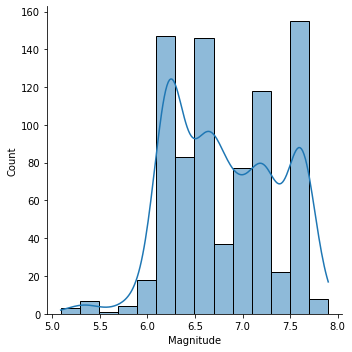

In [124]:
import seaborn as sns
sns.displot(data=gminfo_rotD50, x='Magnitude', kde=True)

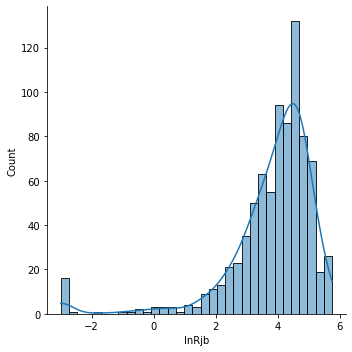

In [119]:
sns.displot(data=gminfo_rotD50, x='lnRjb', kde=True)

<AxesSubplot:xlabel='lnM', ylabel='lnRjb'>

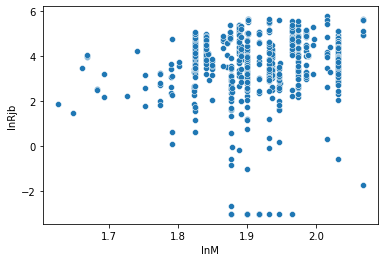

In [122]:
sns.scatterplot(data=gminfo_rotD50, x='lnM', y = 'lnRjb')

In [127]:
sdrX_nocollapse = sdrX[sdrX < 0.1]

In [128]:
sdrX_nocollapse.shape

(821,)

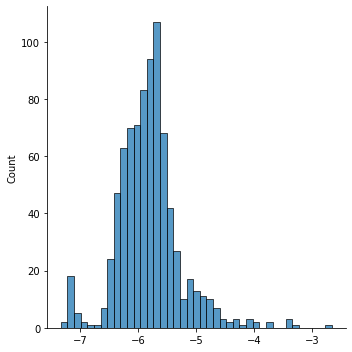

In [130]:
sns.displot(np.log(sdrX_nocollapse))

In [35]:
from scipy.stats import entropy 

kld = entropy(pk=epsilon_onlyIM, qk=epsilon_IM_and_M)
kld

inf

In [44]:
from scipy.special import rel_entr
sum(rel_entr(epsilon_onlyIM, epsilon_IM_and_M))

inf

In [40]:
calc_MI(epsilon_onlyIM, epsilon_IM_and_M, bins=8)

0.23225597534055087

In [58]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values,
        'lnRjb': np.log(gminfo_rotD50['Distance_Rjb'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnEDP   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     796.9
Date:                Fri, 23 Sep 2022   Prob (F-statistic):          9.69e-243
Time:                        11:42:02   Log-Likelihood:                -222.02
No. Observations:                 826   AIC:                             452.0
Df Residuals:                     822   BIC:                             470.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.3409      0.153    -54.389      0.000      -8.642      -8.040
lnSaT1         0.3601      0.016     22.144      0.000       0.328       0.392
M              0.1867      0.021      8.954      0.000       0.146       0.228
lnRjb         -0.1385      0.011    -12.249      0.000      -0.161      -0.116
==============================================================================
Omnibus:                      626.977   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25286.250
Skew:                           2.997   Prob(JB):                         0.00
Kurtosis:                      29.434   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
gminfo_rotD50.head()

,PGA,PGV,DS_5to75,DS_5to95,CAV,T_0.01,T_0.02,T_0.03,T_0.04,T_0.05,...,DSI,Sa_avg,5-75% Duration (sec)_NGA2,5-95% Duration (sec)_NGA2,Magnitude,Distance_Rjb,Distance_rup,Vs_30,lnRjb,lnM
GMID,,,,,,,,,,,,,,,,,,,,,
GM1_RSN9,36.502124,5.937849,19.685,34.455,283.719540,51.430077,51.828501,52.199865,53.467670,60.151525,...,15.522318,88.184618,21.5,37.2,6.50,56.88,56.88,213.44,4.040944,1.871802
GM2_RSN12,41.268564,7.295614,17.045,29.345,366.517457,51.778268,51.878934,52.120331,52.842837,53.337184,...,29.362105,108.306517,18.6,33.5,7.36,114.62,117.75,316.46,4.741622,1.996060
GM3_RSN30,267.680106,15.747787,2.170,7.520,488.062285,372.944795,375.846988,384.420565,393.843876,386.595013,...,29.018868,432.395587,2.4,7.5,6.19,9.58,9.58,289.56,2.259678,1.822935
GM4_RSN31,213.757067,9.276829,3.840,10.840,376.026733,244.018592,249.149985,262.084464,267.504131,291.647979,...,22.814141,263.701266,5.9,13.1,6.19,12.90,12.90,256.82,2.557227,1.822935
GM5_RSN36,44.924604,12.420486,24.580,48.150,511.568742,92.436785,92.892724,93.627472,95.195204,98.252641,...,49.462109,140.320730,25.0,49.3,6.63,45.12,45.66,213.44,3.809326,1.891605


In [140]:
gminfo_rotD50['sa(g)'] = np.round(gminfo_rotD50['T_0.13'].values / g, 2)
dict(gminfo_rotD50['sa(g)'].value_counts())

{0.03: 65,
 0.02: 51,
 0.07: 44,
 0.1: 39,
 0.09: 36,
 0.04: 35,
 0.05: 34,
 0.06: 33,
 0.08: 32,
 0.01: 30,
 0.13: 23,
 0.14: 18,
 0.12: 18,
 0.15: 17,
 0.11: 17,
 0.2: 17,
 0.16: 15,
 0.17: 14,
 0.18: 13,
 0.29: 12,
 0.19: 12,
 0.21: 10,
 0.22: 9,
 0.28: 8,
 0.4: 8,
 0.23: 8,
 0.3: 7,
 0.31: 7,
 0.39: 7,
 0.38: 7,
 0.37: 6,
 0.24: 6,
 0.49: 6,
 0.25: 6,
 0.45: 5,
 0.32: 5,
 0.58: 5,
 0.52: 5,
 0.42: 5,
 0.34: 5,
 0.27: 4,
 0.33: 4,
 0.48: 4,
 0.46: 4,
 0.7: 4,
 0.57: 3,
 0.35: 3,
 0.59: 3,
 0.36: 3,
 0.72: 3,
 1.06: 3,
 0.83: 3,
 0.61: 3,
 0.6: 3,
 0.47: 3,
 1.21: 2,
 0.63: 2,
 0.79: 2,
 1.33: 2,
 0.87: 2,
 0.53: 2,
 1.65: 2,
 0.67: 2,
 0.51: 2,
 1.27: 2,
 1.1: 2,
 0.41: 2,
 0.9: 2,
 0.95: 2,
 0.55: 2,
 0.77: 2,
 1.01: 2,
 0.65: 2,
 0.56: 2,
 0.5: 2,
 0.26: 2,
 0.97: 2,
 1.39: 1,
 0.68: 1,
 1.26: 1,
 1.42: 1,
 0.89: 1,
 2.25: 1,
 0.75: 1,
 1.02: 1,
 0.64: 1,
 0.74: 1,
 0.71: 1,
 1.18: 1,
 0.96: 1,
 1.12: 1,
 1.04: 1,
 1.19: 1,
 1.08: 1,
 1.31: 1,
 0.94: 1,
 0.99: 1,
 0.82: 1,
 1.58: 

In [59]:
epsilon_IM_and_M_and_lnR = model_res.resid

In [60]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_IM_and_M_and_lnR)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

0.001014521011153957

In [32]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'M': gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

NameError: name 'spectral_acc' is not defined

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [47]:
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb + M', data = dummydf)
model_res = model.fit()
model_res.summary()

NameError: name 'spectral_acc' is not defined

In [ ]:
model_res.pvalues

In [ ]:
sdrXx = sdr[3].values[:numGM][1::2]
len(sdrXx)

In [ ]:
linear_fit = sm.OLS(np.log(sdrX), X)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
linear_fit = sm.OLS(np.log(sdrXx), Xx)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues['lnRjb']

a = 'Yes' if model_res.pvalues['lnRjb'] >= 0.05 else 'No'

In [ ]:
np.round(model_res.pvalues['lnRjb'], 2)



In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
sns.histplot(fit_result.resid)

In [ ]:
mu, std = norm.fit(fit_result.resid)
mu, std

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
ols_sdrX_saT1 = OLS(sdrX, sa_T013)

In [ ]:
ols_sdrX_saT1.get_summary()

In [ ]:
ols_sdrX_saT1.plot_model_fit()

In [ ]:
ols_sdrX_saT1.plot_residuals_hist()

In [ ]:
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

In [ ]:
x


In [ ]:
y

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
z